In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '8d4cd999a8074991bd781694d6782845')

In [4]:
key

'8d4cd999a8074991bd781694d6782845'

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [7]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)

In [9]:
fns

(#445) [Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000002.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000004.jpg'),Path('bears/grizzly/00000009.jpg'),Path('bears/grizzly/00000001.jpg'),Path('bears/grizzly/00000008.jpg'),Path('bears/grizzly/00000011.jpg'),Path('bears/grizzly/00000003.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#7) [Path('bears/grizzly/00000062.jpg'),Path('bears/grizzly/00000078.jpg'),Path('bears/grizzly/00000090.jpg'),Path('bears/black/00000119.jpeg'),Path('bears/teddy/00000031.jpg'),Path('bears/teddy/00000110.jpg'),Path('bears/teddy/00000135.jpg')]

In [12]:
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [15]:
dls = bears.dataloaders(path)

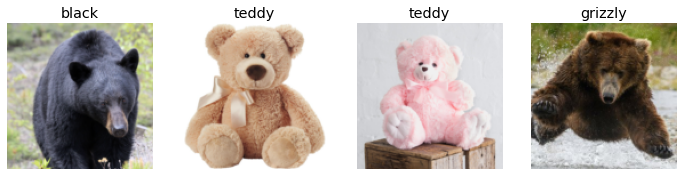

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

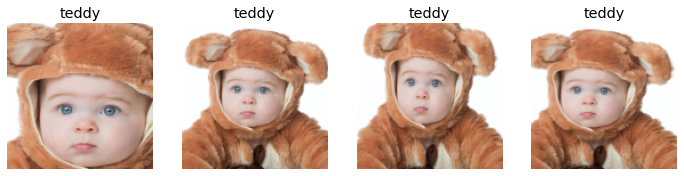

In [18]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

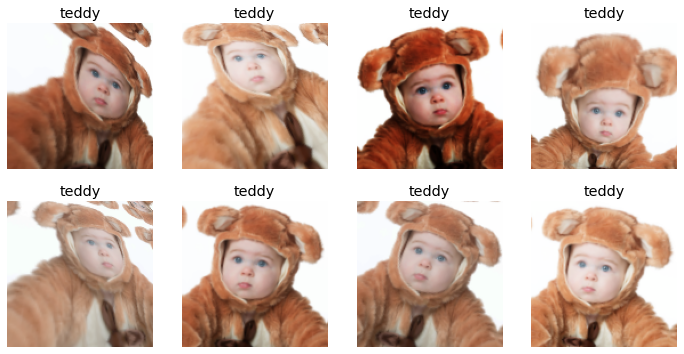

In [19]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [20]:
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale=0.5),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(path)

In [21]:
learn = cnn_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.194778,0.070953,0.034483,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.148004,0.039563,0.022989,00:11
1,0.094729,0.047649,0.022989,00:10
2,0.070612,0.048096,0.011494,00:10
3,0.059833,0.046973,0.011494,00:10


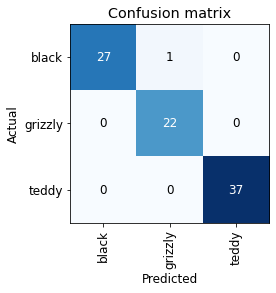

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

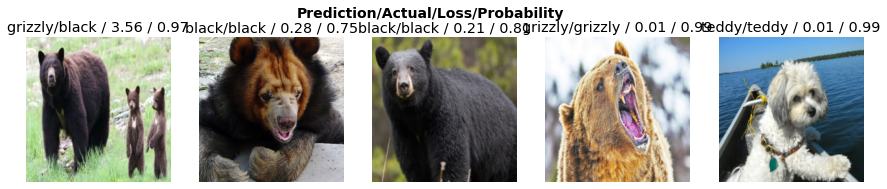

In [31]:
interp.plot_top_losses(5, nrows=1)

In [34]:
learn.export()

In [35]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [36]:
learn_inf = load_learner(path/'export.pkl')

In [38]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorImage(1), TensorImage([2.3528e-07, 1.0000e+00, 2.9222e-09]))

In [39]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [40]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [41]:
img = PILImage.create(btn_upload.data[-1])

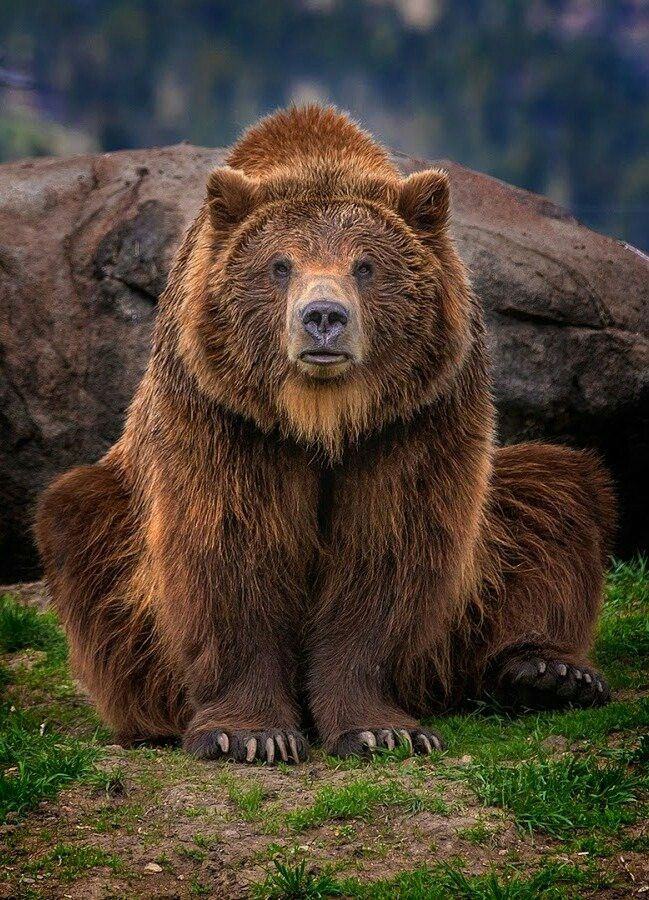

In [42]:
img

In [43]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [44]:
pred, pred_idx, probs = learn_inf.predict(img)

In [45]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx] : .04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability:  1.0000')

In [46]:
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [47]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128, 128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx] : .04f}'

btn_run.on_click(on_click_classify)

In [48]:
btn_upload = widgets.FileUpload()

In [49]:
VBox([widgets.Label('Select your bear!'), btn_upload, btn_run, out_pl, lbl_pred])